In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile
import matplotlib.pylab as plt

import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.5.0
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
os.environ['KAGGLE_USERNAME'] = "bayuadityatriwibowo" # username from the json file
os.environ['KAGGLE_KEY'] = "2afe27d8d4c9644debf51b8e88ad9dbb" # key from the json file
!kaggle datasets download -d bayuadityatriwibowo/bangkits-peasent-dataset --path '/tmp/'

 97% 605M/621M [00:08<00:00, 66.3MB/s]
100% 621M/621M [00:08<00:00, 76.3MB/s]


In [ ]:
local_zip = '/tmp/bangkits-peasent-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"

Corn_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Corn_(maize)___healthy")
Potato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Potato___healthy")
Tomato_healthy = os.path.join("/tmp/Bangkit's Peasant Dataset/train/Tomato___healthy")

print('total training Healthy Corn images:', len(os.listdir(Corn_healthy)))
print('total training Healthy Potato images:', len(os.listdir(Potato_healthy)))
print('total training Healthy Tomato images:', len(os.listdir(Tomato_healthy)))

Corn_files = os.listdir(Corn_healthy)
print(Corn_files[:10])
Potato_files = os.listdir(Potato_healthy)
print(Potato_files[:10])
Tomato_files = os.listdir(Tomato_healthy)
print(Tomato_files[:10])

total training Healthy Corn images: 1859
total training Healthy Potato images: 1824
total training Healthy Tomato images: 1926
['2bbd67e6-0eb0-4569-92fd-bc5fbf4c6570___R.S_HL 8344 copy 2_flipLR.jpg', 'ac10769f-266b-452e-b8ab-671bd3df69c2___R.S_HL 8344 copy.jpg', '354890d4-ba2a-43b3-a97c-f9108c480ccd___R.S_HL 8174 copy 2_flipLR.jpg', '515cfd7f-995c-4843-93f7-dc2c012db476___R.S_HL 7877 copy 2.jpg', '7784be50-f9e7-4268-aa17-80359bc7688a___R.S_HL 8231 copy.jpg', '5a1567d9-a5ee-49fe-8c0c-78a9fe25b213___R.S_HL 8164 copy 2_flipLR.jpg', 'b0222ee7-9fad-4204-8738-15eb8e879001___R.S_HL 8062 copy 2.jpg', '15297d24-b99b-4c9b-91b5-c09057867aef___R.S_HL 8028 copy.jpg', '1003bded-8167-4819-a1d8-627449fe7781___R.S_HL 7991 copy 2.jpg', '9b5d313a-6815-4b9d-ad5d-27114e767112___R.S_HL 8268 copy_flipLR.jpg']
['2dee1571-ef6b-40ef-8c46-334e89aad3f1___RS_HL 1950.JPG', '30126310-39de-4c02-b10a-23409417a4f6___RS_HL 1826_new200degFlipLR.JPG', '77c75478-e1f0-4aaa-9cbc-af1fed928a74___RS_HL 1748_new200degFlipLR.JPG'

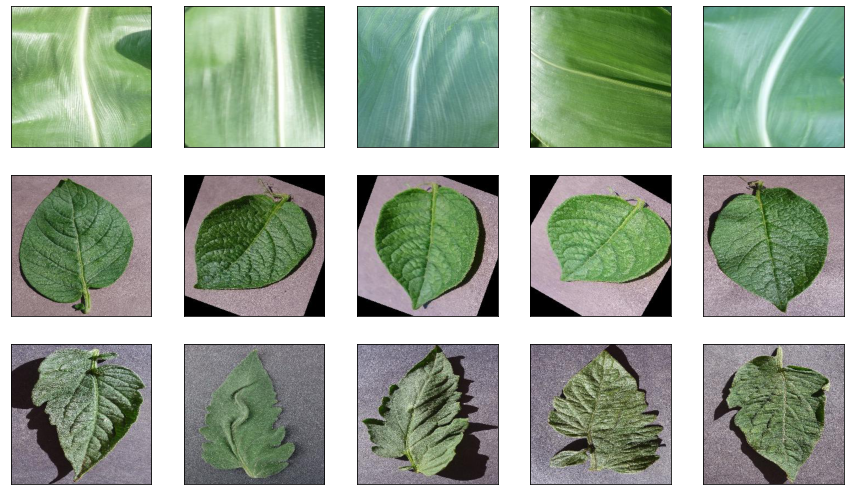

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 5

Corn_img = [os.path.join(Corn_healthy, fname) 
                for fname in Corn_files[pic_index-5:pic_index]]
Potato_img = [os.path.join(Potato_healthy, fname) 
                for fname in Potato_files[pic_index-5:pic_index]]
Tomato_img = [os.path.join(Tomato_healthy, fname) 
                for fname in Tomato_files[pic_index-5:pic_index]]

plt.figure(figsize=(15,15))
for i, img_path in enumerate(Corn_img+Potato_img+Tomato_img):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
plt.show()

In [ ]:
TRAINING_DIR = "/tmp/Bangkit's Peasant Dataset/train/"
training_datagen = ImageDataGenerator(rescale=1./255)

VALIDATION_DIR = "/tmp/Bangkit's Peasant Dataset/val/"
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

Found 31363 images belonging to 17 classes.
Found 7840 images belonging to 17 classes.


## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

Load TFHub Module

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable= False)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(17, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 17)                21777     
Total params: 2,279,761
Trainable params: 21,777
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 5

hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator)

Epoch 1/5
491/491 [==============================] - 116s 170ms/step - loss: 0.5654 - accuracy: 0.8334 - val_loss: 0.3399 - val_accuracy: 0.8969
Epoch 2/5
491/491 [==============================] - 81s 166ms/step - loss: 0.2609 - accuracy: 0.9199 - val_loss: 0.2547 - val_accuracy: 0.9205
Epoch 3/5
491/491 [==============================] - 81s 165ms/step - loss: 0.2047 - accuracy: 0.9367 - val_loss: 0.2431 - val_accuracy: 0.9232
Epoch 4/5
491/491 [==============================] - 81s 165ms/step - loss: 0.1716 - accuracy: 0.9474 - val_loss: 0.2089 - val_accuracy: 0.9338
Epoch 5/5
491/491 [==============================] - 81s 165ms/step - loss: 0.1509 - accuracy: 0.9531 - val_loss: 0.2050 - val_accuracy: 0.9341


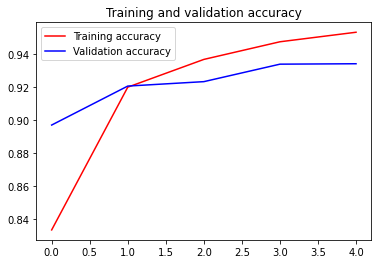

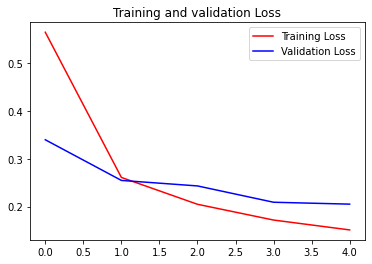

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Saving PotatoHealthy1.JPG to PotatoHealthy1.JPG


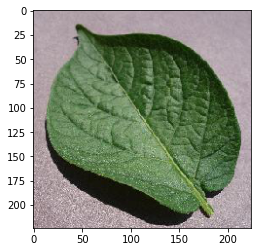

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.00%
Corn_(maize)___Common_rust_: 0.00%
Corn_(maize)___Northern_Leaf_Blight: 0.00%
Corn_(maize)___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.11%
Potato___healthy: 99.89%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Leaf_Mold: 0.00%
Tomato___Septoria_leaf_spot: 0.00%
Tomato___Spider_mites Two-spotted_spider_mite: 0.00%
Tomato___Target_Spot: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = train_generator.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

In [ ]:
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/Bangkit's Peasant Dataset/val",
    seed=42,
    image_size= (224, 224),
    batch_size=64)

class_names = validation_ds.class_names

Found 7840 files belonging to 17 classes.


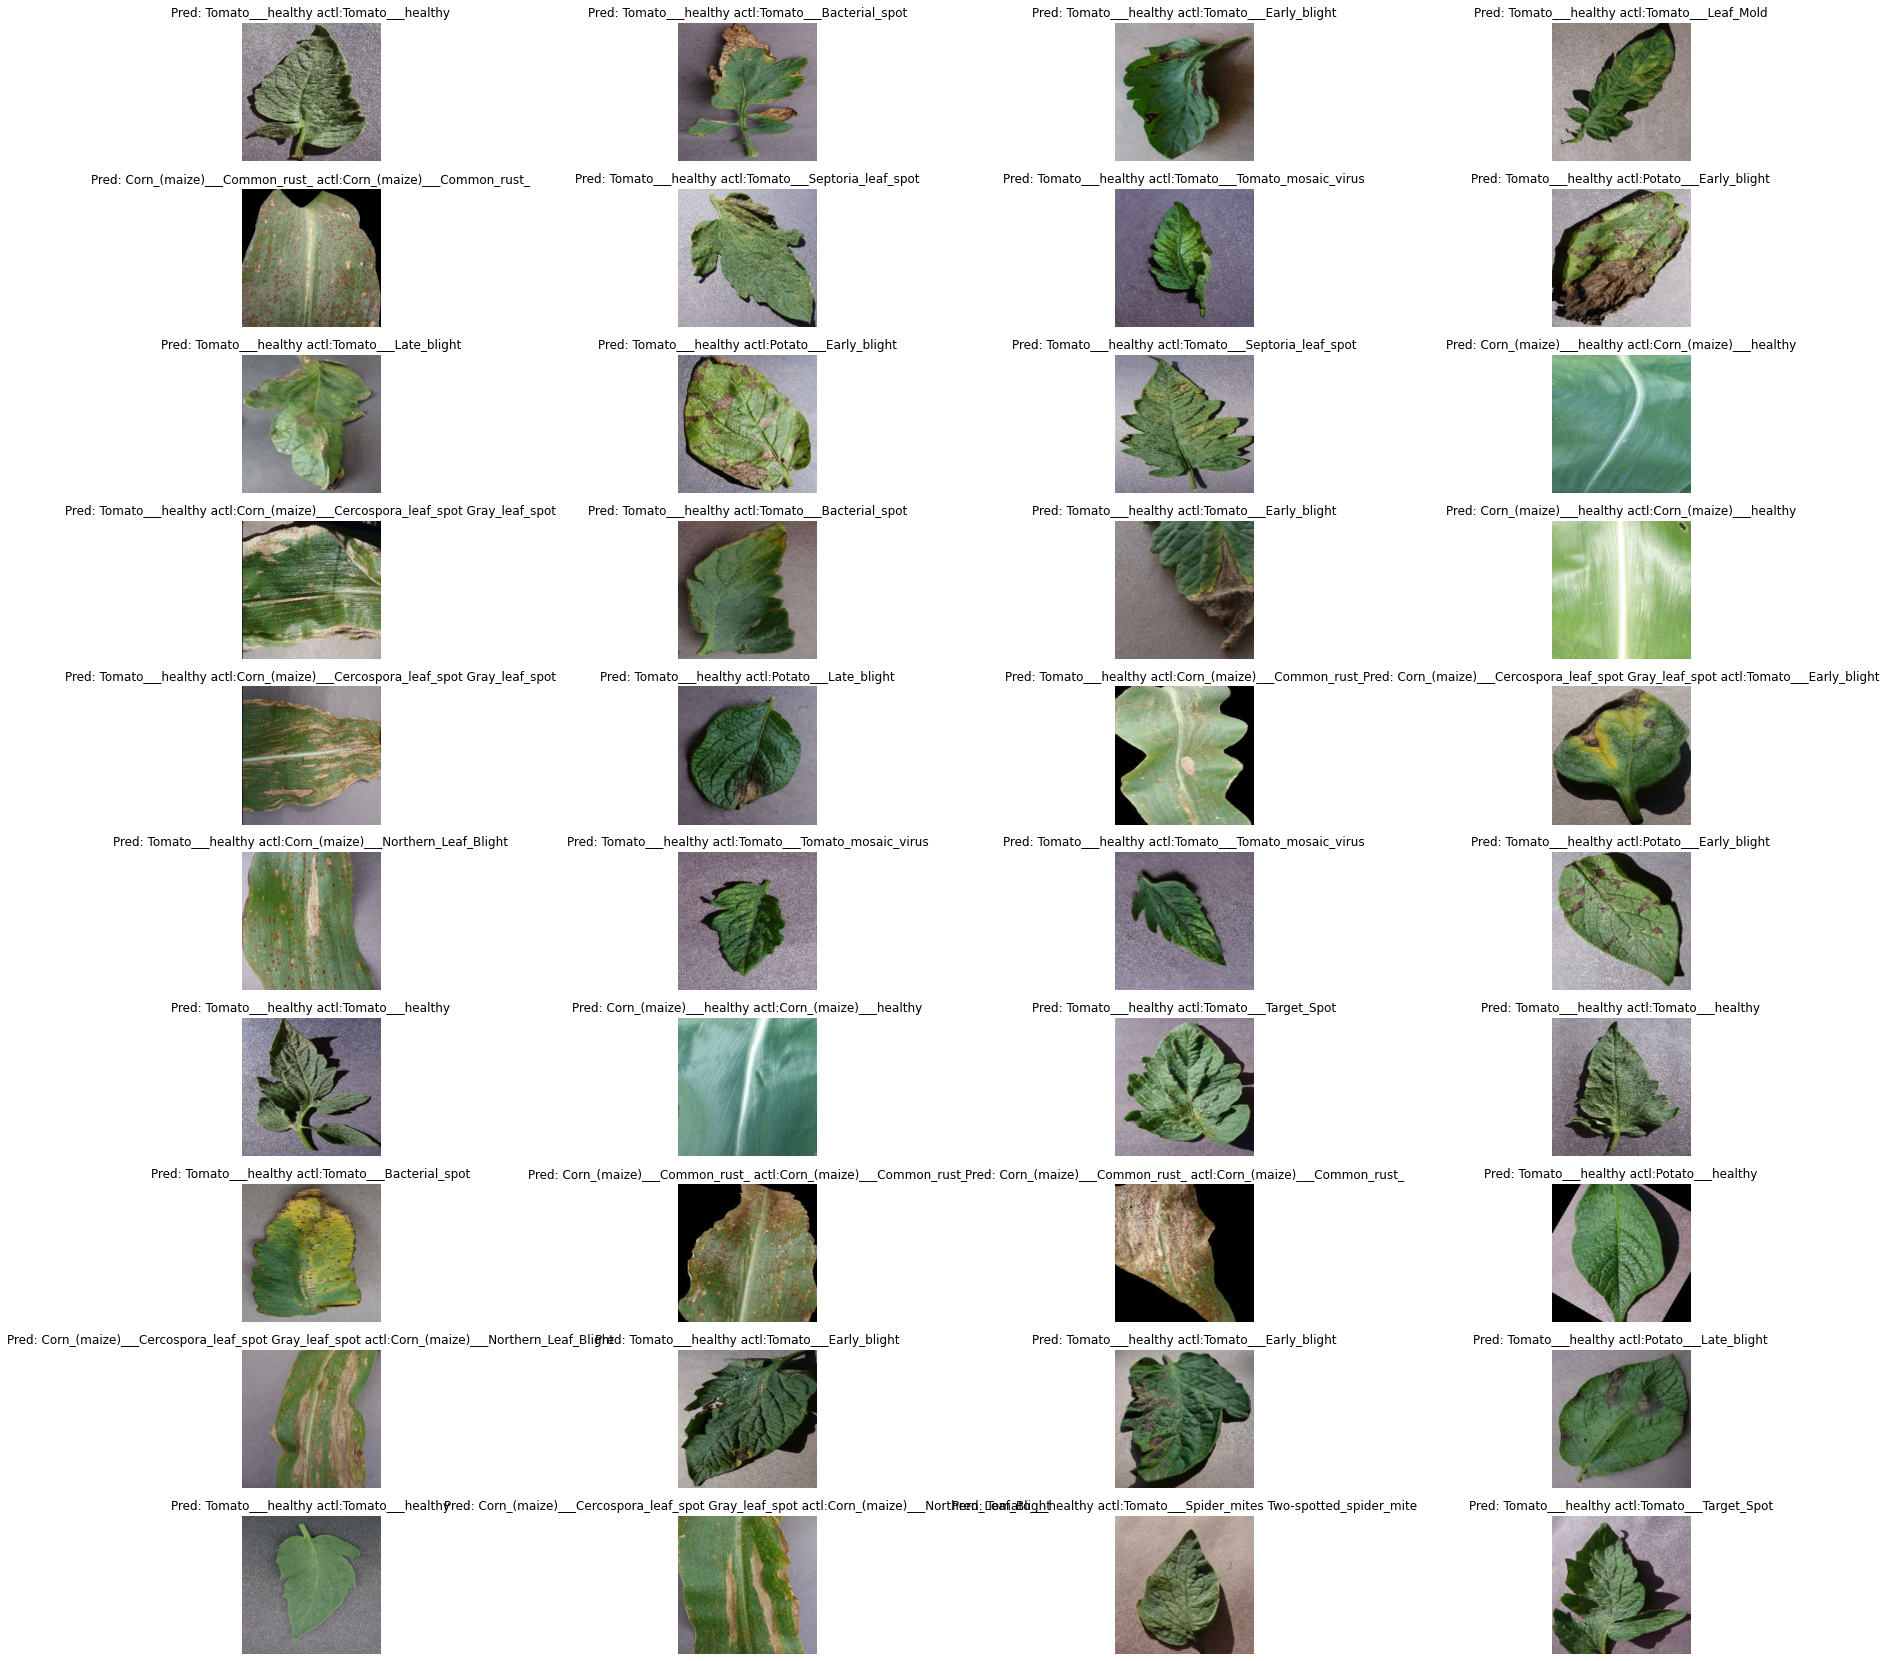

In [ ]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in validation_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
model.save('./v3.h5')

In [ ]:
model_name = 'my_model'
model_version = '0001'
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: my_model/0001/assets


INFO:tensorflow:Assets written to: my_model/0001/assets


In [ ]:
PLANT_DIS_SAVED_MODEL = '/exp_saved_model/'

In [ ]:
tf.saved_model.save(model, PLANT_DIS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /exp_saved_model/assets


INFO:tensorflow:Assets written to: /exp_saved_model/assets


In [ ]:
%%bash -s $PLANT_DIS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 17)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(PLANT_DIS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 17), dtype=tf.float32, name='dense')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(PLANT_DIS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_quant_model = converter.convert()

In [ ]:
import pathlib

tflite_model_file = pathlib.Path('./pdv1.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

2669744

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
!zip -r /content/file.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/0001/ (stored 0%)
  adding: content/my_model/0001/assets/ (stored 0%)
  adding: content/my_model/0001/saved_model.pb (deflated 92%)
  adding: content/my_model/0001/variables/ (stored 0%)
  adding: content/my_model/0001/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_model/0001/variables/variables.index (deflated 78%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>